# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [244]:
p = 0.5
q = 1.0 #Pure YM
run = 1

1

Choose your grid

In [256]:
global compactified=false
global loggrid=false
global bisection=false

false

In [276]:
using Quadmath, Printf

res=m;
N=2.0^m*200.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=10.0
end

dx=Xf/N
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*200.0/2.0
Tf=Nt*dt;

In [277]:
print(N)

200.0

In [278]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

# Grid

In [279]:
using Printf
include("./YangMills.jl");

In [280]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.05
the time step is 0.025


# Initial data of m β Ψ and Ψ,x

In [281]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initrchi=zeros(L)
initderrchiu=zeros(L)
initderpsi=zeros(L)
initderrchir=zeros(L)


#state array is m beta psi rchi rchi,u psi,r rchi,r r
state_array=[initm initbeta initpsi initrchi initderrchiu initderpsi initderrchir initX];

#PSI,R
A=0.075*p*(1−q)
r0=0.75
sigma=0.25

initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)

state_array[:,6] = initderpsi
state_array=ghost(state_array)

#CHI,R
A=0.25*p*q
r0=0.3
sigma=0.1

initderrchir[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)

state_array[:,7] = initderrchir

####
#PSI FROM PSI,R
derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,6],  k=4);
derrchir_func = Spline1D(initX[4:L-3], state_array[4:L-3,7],  k=4);

funcs=[derpsi_func derrchir_func];

In [282]:
state_array

207×8 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0   0.0          -0.15
 0.0  0.0  0.0  0.0  0.0  0.0   0.0          -0.1
 0.0  0.0  0.0  0.0  0.0  0.0   0.0          -0.05
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           0.0
 0.0  0.0  0.0  0.0  0.0  0.0   3.31797e-6    0.05
 0.0  0.0  0.0  0.0  0.0  0.0   0.000160262   0.1
 0.0  0.0  0.0  0.0  0.0  0.0   0.00222326    0.15
 0.0  0.0  0.0  0.0  0.0  0.0   0.0128758     0.2
 0.0  0.0  0.0  0.0  0.0  0.0   0.0334641     0.25
 0.0  0.0  0.0  0.0  0.0  0.0   0.03375       0.3
 0.0  0.0  0.0  0.0  0.0  0.0  -0.00596269    0.35
 0.0  0.0  0.0  0.0  0.0  0.0  -0.0367879     0.4
 0.0  0.0  0.0  0.0  0.0  0.0  -0.0280131     0.45
 ⋮                        ⋮                  
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           9.6
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           9.65
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           9.7
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           9.75
 0.0  0.0  0.0  0.0  0.0  0.0   0.0           9.8
 0.0  0.0  0.0  0.0  0

In [283]:
y0=[0.0 0.0 0.0 0.0 0.0]

state_array[4:L-3,1:5] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,funcs,state_array[:,:]);

#state_array = ghost(state_array);

 
 z5 is 0.0
 
 z5 is -0.006986713520353369
 
 z5 is -0.003493342701261536
 
 z5 is 0.001879391286126571
 
 z5 is 0.0021550941587604
 
 z5 is 0.0025210142212445845
 
 z5 is 0.0026502305275357017
 
 z5 is 0.0034800378438173195
 
 z5 is 0.0035073876842149363
 
 z5 is 0.010400039207935401
 
 z5 is 0.00981932312471051
 
 z5 is 0.028047215307271715
 
 z5 is 0.02771084486629164
 
 z5 is 0.06301570688851613
 
 z5 is 0.06091920407300266
 
 z5 is 0.1193502323836858
 
 z5 is 0.11883067338943262
 
 z5 is 0.18980089455951926
 
 z5 is 0.1871015061626563
 
 z5 is 0.24186020031308808
 
 z5 is 0.24209662630321394
 
 z5 is 0.2481491343163718
 
 z5 is 0.24934631117480643
 
 z5 is 0.18428789889432173
 
 z5 is 0.18524643669984084
 
 z5 is 0.05790895120140234
 
 z5 is 0.06308907695765459
 
 z5 is -0.07806216578352884
 
 z5 is -0.07774408211323448
 
 z5 is -0.18017052095746872
 
 z5 is -0.1764480737990845
 
 z5 is -0.21453092386771405
 
 z5 is -0.21521830695981528
 
 z5 is -0.19207766302564125
 
 z5 is -0.1

 
 z5 is 0.0017527459446291817
 
 z5 is 0.00175400650339346
 
 z5 is 0.0017540064266133748
 
 z5 is 0.0017552446505449376
 
 z5 is 0.0017552511999635323
 
 z5 is 0.0017564676874834912
 
 z5 is 0.0017564676148508062
 
 z5 is 0.0017576628000513263
 
 z5 is 0.0017576690642337398
 
 z5 is 0.001758843511500617
 
 z5 is 0.0017588434427525696
 
 z5 is 0.0017599975612260636
 
 z5 is 0.001760003555344741
 
 z5 is 0.0017611378776708365
 
 z5 is 0.0017611378125636388
 
 z5 is 0.0017622527246337135
 
 z5 is 0.0017622584629154957
 
 z5 is 0.001763354467752681
 
 z5 is 0.0017633544060599907
 
 z5 is 0.0017644318678756415
 
 z5 is 0.001764437363668818
 
 z5 is 0.0017654967578173105
 
 z5 is 0.0017654966993288358
 
 z5 is 0.001766538369788153
 
 z5 is 0.0017665436356242253
 
 z5 is 0.0017675680318853869
 
 z5 is 0.001767567976405618
 
 z5 is 0.0017685754235484375
 
 z5 is 0.0017685804711990505
 
 z5 is 0.0017695713945206871
 
 z5 is 0.0017695713418677337
 
 z5 is 0.0017705460487832923
 
 z5 is 0.00177

 z5 is 0.0018324424549732224
 
 z5 is 0.0018326023367478345
 
 z5 is 0.001832602333977275
 
 z5 is 0.0018327607853632444
 
 z5 is 0.0018327612450551533
 
 z5 is 0.0018329182857714464
 
 z5 is 0.0018329182830811926
 
 z5 is 0.0018330739271567454
 
 z5 is 0.0018330743761759303
 
 z5 is 0.0018332286427520138
 
 z5 is 0.0018332286401392963
 
 z5 is 0.0018333815428330795
 
 z5 is 0.0018333819814866149
 
 z5 is 0.0018335335388818565
 
 z5 is 0.0018335335363440165
 
 z5 is 0.001833683761660545
 
 z5 is 0.0018336841902449937
 
 z5 is 0.0018338331015284217
 
 z5 is 0.0018338330990629063
 
 z5 is 0.0018339807091495605
 
 z5 is 0.0018339811279513914
 
 z5 is 0.0018341274543673262
 
 z5 is 0.0018341274519716822
 
 z5 is 0.0018342725071830003
 
 z5 is 0.0018342729164789844
 
 z5 is 0.0018344167175100249
 
 z5 is 0.001834416715181896
 
 z5 is 0.0018345592741412838
 
 z5 is 0.0018345596741988742
 
 z5 is 0.0018347010076263652
 
 z5 is 0.0018347010053634874
 
 z5 is 0.0018348411250224646
 
 z5 is 0.00

In [284]:
state_array

207×8 Matrix{Float64}:
 0.0   0.0          0.0   0.0           0.0          0.0   0.0          -0.15
 0.0   0.0          0.0   0.0           0.0          0.0   0.0          -0.1
 0.0   0.0          0.0   0.0           0.0          0.0   0.0          -0.05
 0.0   0.0          0.0   0.0           0.0          0.0   0.0           0.0
 0.0  -1.80306e-6   0.0  -2.88348e-6   -0.000159006  0.0   3.31797e-6    0.05
 0.0   5.91314e-7   0.0   5.06833e-7   -2.58592e-5   0.0   0.000160262   0.1
 0.0   7.54127e-5   0.0   4.247e-5      0.000574085  0.0   0.00222326    0.15
 0.0   0.000824708  0.0   0.000363648   0.00386518   0.0   0.0128758     0.2
 0.0   0.004089     0.0   0.00152098    0.0131526    0.0   0.0334641     0.25
 0.0   0.0102798    0.0   0.00337382    0.0249974    0.0   0.03375       0.3
 0.0   0.0141201    0.0   0.00416784    0.0279073    0.0  -0.00596269    0.35
 0.0   0.0114053    0.0   0.00294405    0.019528     0.0  -0.0367879     0.4
 0.0   0.00629258   0.0   0.00119812    0.01016

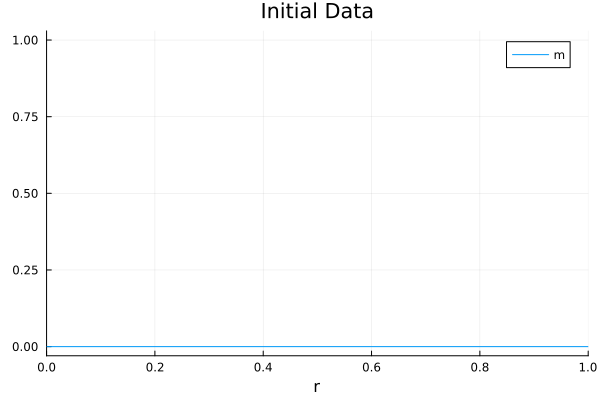

In [255]:
using Plots #showing initial data and the initial status of the horizon finder
plot((initX[4:L-3]), state_array[4:L-3,3], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "psi,x"],xlim=[0,1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [14]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [15]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [16]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.03084271193370367


In [17]:
using Base.Threads
Threads.nthreads()

4

In [18]:
if m==1
    global dt=2e-5
elseif m==2
    global dt=1e-5
else
    global dt=1e-5/2
end

5.0e-6

 ## Time evolution

fixed grid

In [ ]:
finaltime=5.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 500 dt is 5.0e-6, t=0.0024999999999999823 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 1000 dt is 5.0e-6, t=0.00499999999999988 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 1500 dt is 5.0e-6, t=0.0074999999999997785 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 2000 dt is 5.0e-6, t=0.009999999999999678 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 2500 dt is 5.0e-6, t=0.012499999999999576 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 3000 dt is 5.0e-6, t=0.014999999999999474 speed is 0.49999614469816706, dx/dt=249.99999999999997


iteration 3500 dt is 5.0e-6, t=0.017500000000000022 speed is 0.49999614469816717, dx/dt=249.99999999999997


iteration 4000 dt is 5.0e-6, t=0.020000000000000788 speed is 0.49999614469816717, dx/dt=249.99999999999997


iteration 4500 dt is 5.0e-6, t=0.022500000000001553 speed is 0.49999614469816717, dx/dt=249.99999999999997


iteration 5000 dt



iteration 38500 dt is 5.0e-6, t=0.19250000000012213 speed is 0.49999614469817044, dx/dt=249.99999999999997


iteration 39000 dt is 5.0e-6, t=0.19500000000012463 speed is 0.49999614469817055, dx/dt=249.99999999999997


iteration 39500 dt is 5.0e-6, t=0.19750000000012713 speed is 0.4999961446981708, dx/dt=249.99999999999997


iteration 40000 dt is 5.0e-6, t=0.20000000000012963 speed is 0.4999961446981711, dx/dt=249.99999999999997


iteration 40500 dt is 5.0e-6, t=0.20250000000013213 speed is 0.49999614469817133, dx/dt=249.99999999999997


iteration 41000 dt is 5.0e-6, t=0.20500000000013463 speed is 0.49999614469817155, dx/dt=249.99999999999997


iteration 41500 dt is 5.0e-6, t=0.20750000000013713 speed is 0.4999961446981718, dx/dt=249.99999999999997


iteration 42000 dt is 5.0e-6, t=0.21000000000013963 speed is 0.499996144698172, dx/dt=249.99999999999997


iteration 42500 dt is 5.0e-6, t=0.21250000000014213 speed is 0.49999614469817233, dx/dt=249.99999999999997


iteration 43000 dt is 



iteration 76500 dt is 5.0e-6, t=0.3824999999995766 speed is 0.499996144698272, dx/dt=249.99999999999997


iteration 77000 dt is 5.0e-6, t=0.38499999999956525 speed is 0.4999961446982759, dx/dt=249.99999999999997


iteration 77500 dt is 5.0e-6, t=0.38749999999955387 speed is 0.4999961446982801, dx/dt=249.99999999999997


iteration 78000 dt is 5.0e-6, t=0.3899999999995425 speed is 0.49999614469828435, dx/dt=249.99999999999997


iteration 78500 dt is 5.0e-6, t=0.3924999999995311 speed is 0.4999961446982886, dx/dt=249.99999999999997


iteration 79000 dt is 5.0e-6, t=0.39499999999951974 speed is 0.49999614469829323, dx/dt=249.99999999999997


iteration 79500 dt is 5.0e-6, t=0.39749999999950836 speed is 0.49999614469829784, dx/dt=249.99999999999997


iteration 80000 dt is 5.0e-6, t=0.399999999999497 speed is 0.4999961446983027, dx/dt=249.99999999999997


iteration 80500 dt is 5.0e-6, t=0.4024999999994856 speed is 0.49999614469830767, dx/dt=249.99999999999997


iteration 81000 dt is 5.0e-6,



iteration 114500 dt is 5.0e-6, t=0.5724999999995168 speed is 0.4999961446992897, dx/dt=249.99999999999997


iteration 115000 dt is 5.0e-6, t=0.5749999999995332 speed is 0.4999961446993185, dx/dt=249.99999999999997


iteration 115500 dt is 5.0e-6, t=0.5774999999995496 speed is 0.49999614469934794, dx/dt=249.99999999999997


iteration 116000 dt is 5.0e-6, t=0.579999999999566 speed is 0.49999614469937803, dx/dt=249.99999999999997


iteration 116500 dt is 5.0e-6, t=0.5824999999995824 speed is 0.49999614469940856, dx/dt=249.99999999999997


iteration 117000 dt is 5.0e-6, t=0.5849999999995987 speed is 0.49999614469943987, dx/dt=249.99999999999997


iteration 117500 dt is 5.0e-6, t=0.5874999999996151 speed is 0.4999961446994716, dx/dt=249.99999999999997


iteration 118000 dt is 5.0e-6, t=0.5899999999996315 speed is 0.49999614469950404, dx/dt=249.99999999999997


iteration 118500 dt is 5.0e-6, t=0.5924999999996479 speed is 0.499996144699537, dx/dt=249.99999999999997


iteration 119000 dt is 



iteration 152500 dt is 5.0e-6, t=0.7625000000007616 speed is 0.4999961447033288, dx/dt=249.99999999999997


iteration 153000 dt is 5.0e-6, t=0.765000000000778 speed is 0.4999961447034046, dx/dt=249.99999999999997


iteration 153500 dt is 5.0e-6, t=0.7675000000007943 speed is 0.4999961447034807, dx/dt=249.99999999999997


iteration 154000 dt is 5.0e-6, t=0.7700000000008107 speed is 0.4999961447035573, dx/dt=249.99999999999997


iteration 154500 dt is 5.0e-6, t=0.7725000000008271 speed is 0.49999614470363396, dx/dt=249.99999999999997


iteration 155000 dt is 5.0e-6, t=0.7750000000008435 speed is 0.49999614470371095, dx/dt=249.99999999999997


iteration 155500 dt is 5.0e-6, t=0.7775000000008598 speed is 0.49999614470378817, dx/dt=249.99999999999997


iteration 156000 dt is 5.0e-6, t=0.7800000000008762 speed is 0.49999614470386555, dx/dt=249.99999999999997


iteration 156500 dt is 5.0e-6, t=0.7825000000008926 speed is 0.4999961447039433, dx/dt=249.99999999999997


iteration 157000 dt is 



iteration 190500 dt is 5.0e-6, t=0.9525000000020063 speed is 0.49999614470793163, dx/dt=249.99999999999997


iteration 191000 dt is 5.0e-6, t=0.9550000000020227 speed is 0.4999961447079395, dx/dt=249.99999999999997


iteration 191500 dt is 5.0e-6, t=0.957500000002039 speed is 0.4999961447079451, dx/dt=249.99999999999997


iteration 192000 dt is 5.0e-6, t=0.9600000000020554 speed is 0.49999614470794834, dx/dt=249.99999999999997


iteration 192500 dt is 5.0e-6, t=0.9625000000020718 speed is 0.4999961447079489, dx/dt=249.99999999999997


iteration 193000 dt is 5.0e-6, t=0.9650000000020882 speed is 0.4999961447079469, dx/dt=249.99999999999997


iteration 193500 dt is 5.0e-6, t=0.9675000000021046 speed is 0.4999961447079424, dx/dt=249.99999999999997


iteration 194000 dt is 5.0e-6, t=0.9700000000021209 speed is 0.49999614470793535, dx/dt=249.99999999999997


iteration 194500 dt is 5.0e-6, t=0.9725000000021373 speed is 0.4999961447079256, dx/dt=249.99999999999997


iteration 195000 dt is 5



iteration 228500 dt is 5.0e-6, t=1.142500000003251 speed is 0.49999614470144865, dx/dt=249.99999999999997


iteration 229000 dt is 5.0e-6, t=1.1450000000032674 speed is 0.4999961447013122, dx/dt=249.99999999999997


iteration 229500 dt is 5.0e-6, t=1.1475000000032838 speed is 0.499996144701177, dx/dt=249.99999999999997


iteration 230000 dt is 5.0e-6, t=1.1500000000033002 speed is 0.4999961447010434, dx/dt=249.99999999999997


iteration 230500 dt is 5.0e-6, t=1.1525000000033165 speed is 0.49999614470091125, dx/dt=249.99999999999997


iteration 231000 dt is 5.0e-6, t=1.155000000003333 speed is 0.49999614470078096, dx/dt=249.99999999999997


iteration 231500 dt is 5.0e-6, t=1.1575000000033493 speed is 0.49999614470065257, dx/dt=249.99999999999997


iteration 232000 dt is 5.0e-6, t=1.1600000000033657 speed is 0.4999961447005262, dx/dt=249.99999999999997


iteration 232500 dt is 5.0e-6, t=1.162500000003382 speed is 0.4999961447004022, dx/dt=249.99999999999997


iteration 233000 dt is 5.0



iteration 266500 dt is 5.0e-6, t=1.3325000000044958 speed is 0.4999961447036325, dx/dt=249.99999999999997


iteration 267000 dt is 5.0e-6, t=1.3350000000045121 speed is 0.49999614470389486, dx/dt=249.99999999999997


iteration 267500 dt is 5.0e-6, t=1.3375000000045285 speed is 0.49999614470416326, dx/dt=249.99999999999997


iteration 268000 dt is 5.0e-6, t=1.3400000000045449 speed is 0.4999961447044372, dx/dt=249.99999999999997


iteration 268500 dt is 5.0e-6, t=1.3425000000045613 speed is 0.49999614470471676, dx/dt=249.99999999999997


iteration 269000 dt is 5.0e-6, t=1.3450000000045776 speed is 0.499996144705002, dx/dt=249.99999999999997


iteration 269500 dt is 5.0e-6, t=1.347500000004594 speed is 0.49999614470529263, dx/dt=249.99999999999997


iteration 270000 dt is 5.0e-6, t=1.3500000000046104 speed is 0.4999961447055887, dx/dt=249.99999999999997


iteration 270500 dt is 5.0e-6, t=1.3525000000046268 speed is 0.49999614470589, dx/dt=249.99999999999997


iteration 271000 dt is 5.0



iteration 304500 dt is 5.0e-6, t=1.5225000000057405 speed is 0.4999961447342361, dx/dt=249.99999999999997


iteration 305000 dt is 5.0e-6, t=1.5250000000057569 speed is 0.49999614473470966, dx/dt=249.99999999999997


iteration 305500 dt is 5.0e-6, t=1.5275000000057732 speed is 0.49999614473518333, dx/dt=249.99999999999997


iteration 306000 dt is 5.0e-6, t=1.5300000000057896 speed is 0.49999614473565707, dx/dt=249.99999999999997


iteration 306500 dt is 5.0e-6, t=1.532500000005806 speed is 0.49999614473613063, dx/dt=249.99999999999997


iteration 307000 dt is 5.0e-6, t=1.5350000000058224 speed is 0.4999961447366042, dx/dt=249.99999999999997


iteration 307500 dt is 5.0e-6, t=1.5375000000058388 speed is 0.49999614473707743, dx/dt=249.99999999999997


iteration 308000 dt is 5.0e-6, t=1.5400000000058551 speed is 0.49999614473755055, dx/dt=249.99999999999997


iteration 308500 dt is 5.0e-6, t=1.5425000000058715 speed is 0.49999614473802306, dx/dt=249.99999999999997


iteration 309000 dt 



iteration 342500 dt is 5.0e-6, t=1.7125000000069852 speed is 0.49999614475918225, dx/dt=249.99999999999997


iteration 343000 dt is 5.0e-6, t=1.7150000000070016 speed is 0.49999614475906434, dx/dt=249.99999999999997


iteration 343500 dt is 5.0e-6, t=1.717500000007018 speed is 0.49999614475892235, dx/dt=249.99999999999997


iteration 344000 dt is 5.0e-6, t=1.7200000000070343 speed is 0.4999961447587555, dx/dt=249.99999999999997


iteration 344500 dt is 5.0e-6, t=1.7225000000070507 speed is 0.4999961447585631, dx/dt=249.99999999999997


iteration 345000 dt is 5.0e-6, t=1.725000000007067 speed is 0.4999961447583448, dx/dt=249.99999999999997


iteration 345500 dt is 5.0e-6, t=1.7275000000070835 speed is 0.4999961447581003, dx/dt=249.99999999999997


iteration 346000 dt is 5.0e-6, t=1.7300000000070999 speed is 0.4999961447578284, dx/dt=249.99999999999997


iteration 346500 dt is 5.0e-6, t=1.7325000000071162 speed is 0.49999614475752896, dx/dt=249.99999999999997


iteration 347000 dt is 5



iteration 380500 dt is 5.0e-6, t=1.90250000000823 speed is 0.499996144699006, dx/dt=249.99999999999997


iteration 381000 dt is 5.0e-6, t=1.9050000000082463 speed is 0.4999961446988376, dx/dt=249.99999999999997


iteration 381500 dt is 5.0e-6, t=1.9075000000082627 speed is 0.49999614469872244, dx/dt=249.99999999999997


iteration 382000 dt is 5.0e-6, t=1.910000000008279 speed is 0.49999614469865983, dx/dt=249.99999999999997


iteration 382500 dt is 5.0e-6, t=1.9125000000082955 speed is 0.49999614469864884, dx/dt=249.99999999999997


iteration 383000 dt is 5.0e-6, t=1.9150000000083118 speed is 0.4999961446986883, dx/dt=249.99999999999997


iteration 383500 dt is 5.0e-6, t=1.9175000000083282 speed is 0.4999961446987772, dx/dt=249.99999999999997


iteration 384000 dt is 5.0e-6, t=1.9200000000083446 speed is 0.4999961446989139, dx/dt=249.99999999999997


iteration 384500 dt is 5.0e-6, t=1.922500000008361 speed is 0.49999614469909703, dx/dt=249.99999999999997


iteration 385000 dt is 5.0e

#### 

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [48]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

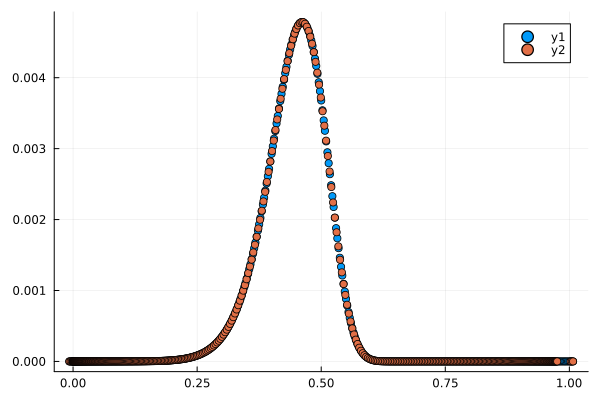

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

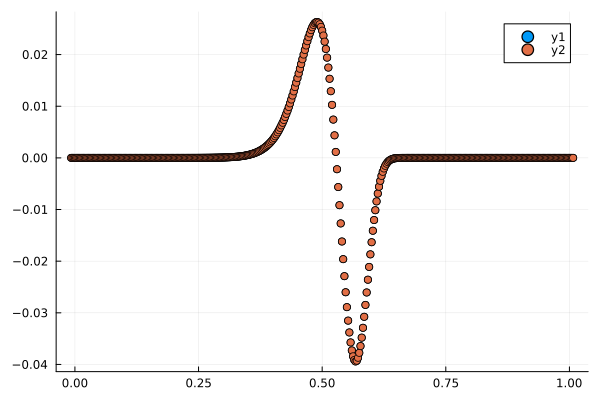

In [417]:
scatter([x1,x1],[y1,y2])